In [118]:
# Moe ParT modified to store router output, accessed via MoeRouterHook

from typing import List, Optional
import timeit
import awkward as ak
import torch
import torch.nn as nn
from torch.nn import Parameter 
from torch.nn.init import xavier_uniform_, xavier_normal_, constant_
import torch
from torch import nn, Tensor
from typing import Optional
import torch.nn.functional as F
from typing import Optional, Tuple
_is_fastpath_enabled: bool = True
from torch.overrides import (
    handle_torch_function,
    has_torch_function,
    has_torch_function_unary,
    has_torch_function_variadic,
)
linear = torch._C._nn.linear
import math
import random
import warnings
import copy
from torch._C import _add_docstr, _infer_size

from functools import partial
from weaver.utils.logger import _logger
import os
import uproot
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch._torch_docs import reproducibility_notes, sparse_support_notes, tf32_notes
import mplhep as hep
import matplotlib.pyplot as plt


In [119]:
# functions to facilitate modded Multihead

def _canonical_mask(
    mask: Optional[Tensor],
    mask_name: str,
    other_type: Optional[torch.dtype],
    other_name: str,
    target_type: torch.dtype,
    check_other: bool = True,
) -> Optional[Tensor]:
    if mask is not None:
        _mask_dtype = mask.dtype
        _mask_is_float = torch.is_floating_point(mask)
        if _mask_dtype != torch.bool and not _mask_is_float:
            raise AssertionError(
                f"only bool and floating types of {mask_name} are supported"
            )
        if check_other and other_type is not None:
            if _mask_dtype != other_type:
                warnings.warn(
                    f"Support for mismatched {mask_name} and {other_name} "
                    "is deprecated. Use same type for both instead."
                )
        if not _mask_is_float:
            mask = torch.zeros_like(mask, dtype=target_type).masked_fill_(
                mask, float("-inf")
            )
    return mask
def _none_or_dtype(input: Optional[Tensor]) -> Optional[torch.dtype]:
    if input is None:
        return None
    elif isinstance(input, torch.Tensor):
        return input.dtype
    raise RuntimeError("input to _none_or_dtype() must be None or torch.Tensor")
def get_fastpath_enabled() -> bool:
    """Returns whether fast path for TransformerEncoder and MultiHeadAttention
    is enabled, or ``True`` if jit is scripting.

    ..note:
        The fastpath might not be run even if ``get_fastpath_enabled`` returns
        ``True`` unless all conditions on inputs are met.
    """
    if not torch.jit.is_scripting():
        return _is_fastpath_enabled
    return True

def _in_projection_packed(
    q: Tensor,
    k: Tensor,
    v: Tensor,
    w: Tensor,
    b: Optional[Tensor] = None,
) -> List[Tensor]:
    r"""Perform the in-projection step of the attention operation, using packed weights.

    Output is a triple containing projection tensors for query, key and value.

    Args:
        q, k, v: query, key and value tensors to be projected. For self-attention,
            these are typically the same tensor; for encoder-decoder attention,
            k and v are typically the same tensor. (We take advantage of these
            identities for performance if they are present.) Regardless, q, k and v
            must share a common embedding dimension; otherwise their shapes may vary.
        w: projection weights for q, k and v, packed into a single tensor. Weights
            are packed along dimension 0, in q, k, v order.
        b: optional projection biases for q, k and v, packed into a single tensor
            in q, k, v order.

    Shape:
        Inputs:
        - q: :math:`(..., E)` where E is the embedding dimension
        - k: :math:`(..., E)` where E is the embedding dimension
        - v: :math:`(..., E)` where E is the embedding dimension
        - w: :math:`(E * 3, E)` where E is the embedding dimension
        - b: :math:`E * 3` where E is the embedding dimension

        Output:
        - in output list :math:`[q', k', v']`, each output tensor will have the
            same shape as the corresponding input tensor.
    """
    E = q.size(-1)
    if k is v:
        if q is k:
            # self-attention
            proj = linear(q, w, b)
            # reshape to 3, E and not E, 3 is deliberate for better memory coalescing and keeping same order as chunk()
            proj = (
                proj.unflatten(-1, (3, E))
                .unsqueeze(0)
                .transpose(0, -2)
                .squeeze(-2)
                .contiguous()
            )
            return proj[0], proj[1], proj[2]
        else:
            # encoder-decoder attention
            w_q, w_kv = w.split([E, E * 2])
            if b is None:
                b_q = b_kv = None
            else:
                b_q, b_kv = b.split([E, E * 2])
            q_proj = linear(q, w_q, b_q)
            kv_proj = linear(k, w_kv, b_kv)
            # reshape to 2, E and not E, 2 is deliberate for better memory coalescing and keeping same order as chunk()
            kv_proj = (
                kv_proj.unflatten(-1, (2, E))
                .unsqueeze(0)
                .transpose(0, -2)
                .squeeze(-2)
                .contiguous()
            )
            return (q_proj, kv_proj[0], kv_proj[1])
    else:
        w_q, w_k, w_v = w.chunk(3)
        if b is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = b.chunk(3)
        return linear(q, w_q, b_q), linear(k, w_k, b_k), linear(v, w_v, b_v)

def _mha_shape_check(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    key_padding_mask: Optional[Tensor],
    attn_mask: Optional[Tensor],
    num_heads: int,
):
    # Verifies the expected shape for `query, `key`, `value`, `key_padding_mask` and `attn_mask`
    # and returns if the input is batched or not.
    # Raises an error if `query` is not 2-D (unbatched) or 3-D (batched) tensor.

    # Shape check.
    if query.dim() == 3:
        # Batched Inputs
        is_batched = True
        assert key.dim() == 3 and value.dim() == 3, (
            "For batched (3-D) `query`, expected `key` and `value` to be 3-D"
            f" but found {key.dim()}-D and {value.dim()}-D tensors respectively"
        )
        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 2, (
                "For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D"
                f" but found {key_padding_mask.dim()}-D tensor instead"
            )
        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), (
                "For batched (3-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                f" but found {attn_mask.dim()}-D tensor instead"
            )
    elif query.dim() == 2:
        # Unbatched Inputs
        is_batched = False
        assert key.dim() == 2 and value.dim() == 2, (
            "For unbatched (2-D) `query`, expected `key` and `value` to be 2-D"
            f" but found {key.dim()}-D and {value.dim()}-D tensors respectively"
        )

        if key_padding_mask is not None:
            assert key_padding_mask.dim() == 1, (
                "For unbatched (2-D) `query`, expected `key_padding_mask` to be `None` or 1-D"
                f" but found {key_padding_mask.dim()}-D tensor instead"
            )

        if attn_mask is not None:
            assert attn_mask.dim() in (2, 3), (
                "For unbatched (2-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                f" but found {attn_mask.dim()}-D tensor instead"
            )
            if attn_mask.dim() == 3:
                expected_shape = (num_heads, query.shape[0], key.shape[0])
                assert (
                    attn_mask.shape == expected_shape
                ), f"Expected `attn_mask` shape to be {expected_shape} but got {attn_mask.shape}"
    else:
        raise AssertionError(
            f"query should be unbatched 2D or batched 3D tensor but received {query.dim()}-D query tensor"
        )

    return is_batched

def set_fastpath_enabled(value: bool) -> None:
    """Sets whether fast path is enabled"""
    global _is_fastpath_enabled
    _is_fastpath_enabled = value


def multi_head_attention_forward(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    embed_dim_to_check: int,
    num_heads: int,
    in_proj_weight: Optional[Tensor],
    in_proj_bias: Optional[Tensor],
    bias_k: Optional[Tensor],
    bias_v: Optional[Tensor],
    add_zero_attn: bool,
    dropout_p: float,
    out_proj_weight: Tensor,
    out_proj_bias: Optional[Tensor],
    training: bool = True,
    key_padding_mask: Optional[Tensor] = None,
    need_weights: bool = True,
    attn_mask: Optional[Tensor] = None,
    use_separate_proj_weight: bool = False,
    q_proj_weight: Optional[Tensor] = None,
    k_proj_weight: Optional[Tensor] = None,
    v_proj_weight: Optional[Tensor] = None,
    static_k: Optional[Tensor] = None,
    static_v: Optional[Tensor] = None,
    average_attn_weights: bool = True,
    is_causal: bool = False,
    return_pre_softmax: bool = False,
) -> Tuple[Tensor, Optional[Tensor]]:
    r"""Forward method for MultiHeadAttention.

    See :class:`torch.nn.MultiheadAttention` for details.

    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        embed_dim_to_check: total dimension of the model.
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
            Default: `True`
            Note: `needs_weight` defaults to `True`, but should be set to `False`
            For best performance when attention weights are not needed.
            *Setting needs_weights to `True`
            leads to a significant performance degradation.*
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        is_causal: If specified, applies a causal mask as attention mask, and ignores
            attn_mask for computing scaled dot product attention.
            Default: ``False``.
            .. warning::
                is_causal is provides a hint that the attn_mask is the
                causal mask.Providing incorrect hints can result in
                incorrect execution, including forward and backward
                compatibility.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.
        average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across heads.
            Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an effect
            when ``need_weights=True.``. Default: True


    Shape:
        Inputs:
        - query: :math:`(L, E)` or :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, E)` or :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, E)` or :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(S)` or :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a FloatTensor is provided, it will be directly added to the value.
          If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        - static_v: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.

        Outputs:
        - attn_output: :math:`(L, E)` or :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: Only returned when ``need_weights=True``. If ``average_attn_weights=True``, returns
          attention weights averaged across heads of shape :math:`(L, S)` when input is unbatched or
          :math:`(N, L, S)`, where :math:`N` is the batch size, :math:`L` is the target sequence length, and
          :math:`S` is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(num_heads, L, S)` when input is unbatched or :math:`(N, num_heads, L, S)`.
    """
    tens_ops = (
        query,
        key,
        value,
        in_proj_weight,
        in_proj_bias,
        bias_k,
        bias_v,
        out_proj_weight,
        out_proj_bias,
    )
    if has_torch_function(tens_ops):
        return handle_torch_function(
            multi_head_attention_forward,
            tens_ops,
            query,
            key,
            value,
            embed_dim_to_check,
            num_heads,
            in_proj_weight,
            in_proj_bias,
            bias_k,
            bias_v,
            add_zero_attn,
            dropout_p,
            out_proj_weight,
            out_proj_bias,
            training=training,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            attn_mask=attn_mask,
            is_causal=is_causal,
            use_separate_proj_weight=use_separate_proj_weight,
            q_proj_weight=q_proj_weight,
            k_proj_weight=k_proj_weight,
            v_proj_weight=v_proj_weight,
            static_k=static_k,
            static_v=static_v,
            average_attn_weights=average_attn_weights,
            return_pre_softmax=return_pre_softmax,
        )

    is_batched = _mha_shape_check(
        query, key, value, key_padding_mask, attn_mask, num_heads
    )

    # For unbatched input, we unsqueeze at the expected batch-dim to pretend that the input
    # is batched, run the computation and before returning squeeze the
    # batch dimension so that the output doesn't carry this temporary batch dimension.
    if not is_batched:
        # unsqueeze if the input is unbatched
        query = query.unsqueeze(1)
        key = key.unsqueeze(1)
        value = value.unsqueeze(1)
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(0)

    # set up shape vars
    tgt_len, bsz, embed_dim = query.shape
    src_len, _, _ = key.shape

    key_padding_mask = _canonical_mask(
        mask=key_padding_mask,
        mask_name="key_padding_mask",
        other_type=_none_or_dtype(attn_mask),
        other_name="attn_mask",
        target_type=query.dtype,
    )

    if is_causal and attn_mask is None:
        raise RuntimeError(
            "Need attn_mask if specifying the is_causal hint. "
            "You may use the Transformer module method "
            "`generate_square_subsequent_mask` to create this mask."
        )

    if is_causal and key_padding_mask is None and not need_weights:
        # when we have a kpm or need weights, we need attn_mask
        # Otherwise, we use the is_causal hint go as is_causal
        # indicator to SDPA.
        attn_mask = None
    else:
        attn_mask = _canonical_mask(
            mask=attn_mask,
            mask_name="attn_mask",
            other_type=None,
            other_name="",
            target_type=query.dtype,
            check_other=False,
        )

        if key_padding_mask is not None:
            # We have the attn_mask, and use that to merge kpm into it.
            # Turn off use of is_causal hint, as the merged mask is no
            # longer causal.
            is_causal = False

    assert embed_dim == embed_dim_to_check, (
        f"was expecting embedding dimension of {embed_dim_to_check}, but got {embed_dim}"
    )
    if isinstance(embed_dim, torch.Tensor):
        # embed_dim can be a tensor when JIT tracing
        head_dim = embed_dim.div(num_heads, rounding_mode="trunc")
    else:
        head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, (
        f"embed_dim {embed_dim} not divisible by num_heads {num_heads}"
    )
    if use_separate_proj_weight:
        # allow MHA to have different embedding dimensions when separate projection weights are used
        assert key.shape[:2] == value.shape[:2], (
            f"key's sequence and batch dims {key.shape[:2]} do not match value's {value.shape[:2]}"
        )
    else:
        assert key.shape == value.shape, (
            f"key shape {key.shape} does not match value shape {value.shape}"
        )

    #
    # compute in-projection
    #
    if not use_separate_proj_weight:
        assert in_proj_weight is not None, (
            "use_separate_proj_weight is False but in_proj_weight is None"
        )
        q, k, v = _in_projection_packed(query, key, value, in_proj_weight, in_proj_bias)
    else:
        assert q_proj_weight is not None, (
            "use_separate_proj_weight is True but q_proj_weight is None"
        )
        assert k_proj_weight is not None, (
            "use_separate_proj_weight is True but k_proj_weight is None"
        )
        assert v_proj_weight is not None, (
            "use_separate_proj_weight is True but v_proj_weight is None"
        )
        if in_proj_bias is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = in_proj_bias.chunk(3)
        q, k, v = _in_projection(
            query,
            key,
            value,
            q_proj_weight,
            k_proj_weight,
            v_proj_weight,
            b_q,
            b_k,
            b_v,
        )

    # prep attention mask

    if attn_mask is not None:
        # ensure attn_mask's dim is 3
        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            if attn_mask.shape != correct_2d_size:
                raise RuntimeError(
                    f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}."
                )
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
            if attn_mask.shape != correct_3d_size:
                raise RuntimeError(
                    f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}."
                )
        else:
            raise RuntimeError(
                f"attn_mask's dimension {attn_mask.dim()} is not supported"
            )

    # add bias along batch dimension (currently second)
    if bias_k is not None and bias_v is not None:
        assert static_k is None, "bias cannot be added to static key."
        assert static_v is None, "bias cannot be added to static value."
        k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
        v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))
    else:
        assert bias_k is None
        assert bias_v is None

    #
    # reshape q, k, v for multihead attention and make them batch first
    #
    q = q.view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if static_k is None:
        k = k.view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_k.size(0) == bsz * num_heads, (
            f"expecting static_k.size(0) of {bsz * num_heads}, but got {static_k.size(0)}"
        )
        assert static_k.size(2) == head_dim, (
            f"expecting static_k.size(2) of {head_dim}, but got {static_k.size(2)}"
        )
        k = static_k
    if static_v is None:
        v = v.view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
    else:
        # TODO finish disentangling control flow so we don't do in-projections when statics are passed
        assert static_v.size(0) == bsz * num_heads, (
            f"expecting static_v.size(0) of {bsz * num_heads}, but got {static_v.size(0)}"
        )
        assert static_v.size(2) == head_dim, (
            f"expecting static_v.size(2) of {head_dim}, but got {static_v.size(2)}"
        )
        v = static_v

    # add zero attention along batch dimension (now first)
    if add_zero_attn:
        zero_attn_shape = (bsz * num_heads, 1, head_dim)
        k = torch.cat(
            [k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1
        )
        v = torch.cat(
            [v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1
        )
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    # update source sequence length after adjustments
    src_len = k.size(1)

    # merge key padding and attention masks
    if key_padding_mask is not None:
        assert key_padding_mask.shape == (
            bsz,
            src_len,
        ), f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = (
            key_padding_mask.view(bsz, 1, 1, src_len)
            .expand(-1, num_heads, -1, -1)
            .reshape(bsz * num_heads, 1, src_len)
        )
        if attn_mask is None:
            attn_mask = key_padding_mask
        else:
            attn_mask = attn_mask + key_padding_mask

    # adjust dropout probability
    if not training:
        dropout_p = 0.0

    #
    # (deep breath) calculate attention and out projection
    #

    if need_weights:
        _B, _Nt, E = q.shape
        q_scaled = q * math.sqrt(1.0 / float(E))

        assert not (is_causal and attn_mask is None), (
            "FIXME: is_causal not implemented for need_weights"
        )

        if attn_mask is not None:
            pre_softmax_interaction = attn_mask
            pre_softmax_interaction.detach()
            pre_softmax_attention = torch.bmm(q_scaled, k.transpose(-2, -1))
            pre_softmax_attention.detach()
            attn_output_weights = torch.baddbmm(
                attn_mask, q_scaled, k.transpose(-2, -1)
            )
        else:
            attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1))
        
        attn_output_weights = torch.softmax(attn_output_weights, dim=-1)
        if dropout_p > 0.0:
            attn_output_weights = torch.dropout(attn_output_weights, p=dropout_p, train=training)

        attn_output = torch.bmm(attn_output_weights, v)

        attn_output = (
            attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, embed_dim)
        )
        attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
        attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))

        # optionally average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        if average_attn_weights:
            attn_output_weights = attn_output_weights.mean(dim=1)

        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
            attn_output_weights = attn_output_weights.squeeze(0)
        if return_pre_softmax:
            return attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction
        else:
            return attn_output, attn_output_weights
    else:
        # attn_mask can be either (L,S) or (N*num_heads, L, S)
        # if attn_mask's shape is (1, L, S) we need to unsqueeze to (1, 1, L, S)
        # in order to match the input for SDPA of (N, num_heads, L, S)
        if attn_mask is not None:
            if attn_mask.size(0) == 1 and attn_mask.dim() == 3:
                attn_mask = attn_mask.unsqueeze(0)
            else:
                attn_mask = attn_mask.view(bsz, num_heads, -1, src_len)

        q = q.view(bsz, num_heads, tgt_len, head_dim)
        k = k.view(bsz, num_heads, src_len, head_dim)
        v = v.view(bsz, num_heads, src_len, head_dim)

        attn_output = scaled_dot_product_attention(
            q, k, v, attn_mask, dropout_p, is_causal
        )
        attn_output = (
            attn_output.permute(2, 0, 1, 3).contiguous().view(bsz * tgt_len, embed_dim)
        )

        attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
        attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))
        if not is_batched:
            # squeeze the output if input was unbatched
            attn_output = attn_output.squeeze(1)
        return attn_output, None


In [120]:
# Modified Multihead to get pre-softmax

class MultiheadAttention(nn.Module):
    r"""Allows the model to jointly attend to information from different representation subspaces.

    This MultiheadAttention layer implements the original architecture described
    in the `Attention Is All You Need <https://arxiv.org/abs/1706.03762>`_ paper. The
    intent of this layer is as a reference implementation for foundational understanding
    and thus it contains only limited features relative to newer architectures.
    Given the fast pace of innovation in transformer-like architectures, we recommend
    exploring this `tutorial <https://pytorch.org/tutorials/intermediate/transformer_building_blocks.html>`_
    to build efficient layers from building blocks in core or using higher
    level libraries from the `PyTorch Ecosystem <https://landscape.pytorch.org/>`_.

    Multi-Head Attention is defined as:

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,\dots,\text{head}_h)W^O

    where :math:`\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)`.

    ``nn.MultiheadAttention`` will use the optimized implementations of
    ``scaled_dot_product_attention()`` when possible.

    In addition to support for the new ``scaled_dot_product_attention()``
    function, for speeding up Inference, MHA will use
    fastpath inference with support for Nested Tensors, iff:

    - self attention is being computed (i.e., ``query``, ``key``, and ``value`` are the same tensor).
    - inputs are batched (3D) with ``batch_first==True``
    - Either autograd is disabled (using ``torch.inference_mode`` or ``torch.no_grad``) or no tensor argument ``requires_grad``
    - training is disabled (using ``.eval()``)
    - ``add_bias_kv`` is ``False``
    - ``add_zero_attn`` is ``False``
    - ``kdim`` and ``vdim`` are equal to ``embed_dim``
    - if a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ is passed, neither ``key_padding_mask``
      nor ``attn_mask`` is passed
    - autocast is disabled

    If the optimized inference fastpath implementation is in use, a
    `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ can be passed for
    ``query``/``key``/``value`` to represent padding more efficiently than using a
    padding mask. In this case, a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_
    will be returned, and an additional speedup proportional to the fraction of the input
    that is padding can be expected.

    Args:
        embed_dim: Total dimension of the model.
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
        bias: If specified, adds bias to input / output projection layers. Default: ``True``.
        add_bias_kv: If specified, adds bias to the key and value sequences at dim=0. Default: ``False``.
        add_zero_attn: If specified, adds a new batch of zeros to the key and value sequences at dim=1.
            Default: ``False``.
        kdim: Total number of features for keys. Default: ``None`` (uses ``kdim=embed_dim``).
        vdim: Total number of features for values. Default: ``None`` (uses ``vdim=embed_dim``).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Examples::

        >>> # xdoctest: +SKIP
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    .. _`FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness`:
         https://arxiv.org/abs/2205.14135

    """

    __constants__ = ["batch_first"]
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(
        self,
        embed_dim,
        num_heads,
        dropout=0.0,
        bias=True,
        add_bias_kv=False,
        add_zero_attn=False,
        kdim=None,
        vdim=None,
        batch_first=False,
        device=None,
        dtype=None,
        return_pre_softmax: bool = False,
    ) -> None:
        if embed_dim <= 0 or num_heads <= 0:
            raise ValueError(
                f"embed_dim and num_heads must be greater than 0,"
                f" got embed_dim={embed_dim} and num_heads={num_heads} instead"
            )
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.return_pre_softmax = return_pre_softmax
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, (
            "embed_dim must be divisible by num_heads"
        )

        if not self._qkv_same_embed_dim:
            self.q_proj_weight = Parameter(
                torch.empty((embed_dim, embed_dim), **factory_kwargs)
            )
            self.k_proj_weight = Parameter(
                torch.empty((embed_dim, self.kdim), **factory_kwargs)
            )
            self.v_proj_weight = Parameter(
                torch.empty((embed_dim, self.vdim), **factory_kwargs)
            )
            self.register_parameter("in_proj_weight", None)
        else:
            self.in_proj_weight = Parameter(
                torch.empty((3 * embed_dim, embed_dim), **factory_kwargs)
            )
            self.register_parameter("q_proj_weight", None)
            self.register_parameter("k_proj_weight", None)
            self.register_parameter("v_proj_weight", None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter("in_proj_bias", None)
        self.out_proj = nn.Linear(
            embed_dim, embed_dim, bias=bias, **factory_kwargs
        )

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self) -> None:
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.0)
            constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if "_qkv_same_embed_dim" not in state:
            state["_qkv_same_embed_dim"] = True

        super().__setstate__(state)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        key_padding_mask: Optional[Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[Tensor] = None,
        average_attn_weights: bool = True,
        is_causal: bool = False,
        return_pre_softmax: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        r"""Compute attention outputs using query, key, and value embeddings.

            Supports optional parameters for padding, masks and attention weights.

        Args:
            query: Query embeddings of shape :math:`(L, E_q)` for unbatched input, :math:`(L, N, E_q)` when ``batch_first=False``
                or :math:`(N, L, E_q)` when ``batch_first=True``, where :math:`L` is the target sequence length,
                :math:`N` is the batch size, and :math:`E_q` is the query embedding dimension ``embed_dim``.
                Queries are compared against key-value pairs to produce the output.
                See "Attention Is All You Need" for more details.
            key: Key embeddings of shape :math:`(S, E_k)` for unbatched input, :math:`(S, N, E_k)` when ``batch_first=False``
                or :math:`(N, S, E_k)` when ``batch_first=True``, where :math:`S` is the source sequence length,
                :math:`N` is the batch size, and :math:`E_k` is the key embedding dimension ``kdim``.
                See "Attention Is All You Need" for more details.
            value: Value embeddings of shape :math:`(S, E_v)` for unbatched input, :math:`(S, N, E_v)` when
                ``batch_first=False`` or :math:`(N, S, E_v)` when ``batch_first=True``, where :math:`S` is the source
                sequence length, :math:`N` is the batch size, and :math:`E_v` is the value embedding dimension ``vdim``.
                See "Attention Is All You Need" for more details.
            key_padding_mask: If specified, a mask of shape :math:`(N, S)` indicating which elements within ``key``
                to ignore for the purpose of attention (i.e. treat as "padding"). For unbatched `query`, shape should be :math:`(S)`.
                Binary and float masks are supported.
                For a binary mask, a ``True`` value indicates that the corresponding ``key`` value will be ignored for
                the purpose of attention. For a float mask, it will be directly added to the corresponding ``key`` value.
            need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
                Set ``need_weights=False`` to use the optimized ``scaled_dot_product_attention``
                and achieve the best performance for MHA.
                Default: ``True``.
            attn_mask: If specified, a 2D or 3D mask preventing attention to certain positions. Must be of shape
                :math:`(L, S)` or :math:`(N\cdot\text{num\_heads}, L, S)`, where :math:`N` is the batch size,
                :math:`L` is the target sequence length, and :math:`S` is the source sequence length. A 2D mask will be
                broadcasted across the batch while a 3D mask allows for a different mask for each entry in the batch.
                Binary and float masks are supported. For a binary mask, a ``True`` value indicates that the
                corresponding position is not allowed to attend. For a float mask, the mask values will be added to
                the attention weight.
                If both attn_mask and key_padding_mask are supplied, their types should match.
            average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
                heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
                effect when ``need_weights=True``. Default: ``True`` (i.e. average weights across heads)
            is_causal: If specified, applies a causal mask as attention mask.
                Default: ``False``.
                Warning:
                ``is_causal`` provides a hint that ``attn_mask`` is the
                causal mask. Providing incorrect hints can result in
                incorrect execution, including forward and backward
                compatibility.

        Outputs:
            - **attn_output** - Attention outputs of shape :math:`(L, E)` when input is unbatched,
              :math:`(L, N, E)` when ``batch_first=False`` or :math:`(N, L, E)` when ``batch_first=True``,
              where :math:`L` is the target sequence length, :math:`N` is the batch size, and :math:`E` is the
              embedding dimension ``embed_dim``.
            - **attn_output_weights** - Only returned when ``need_weights=True``. If ``average_attn_weights=True``,
              returns attention weights averaged across heads of shape :math:`(L, S)` when input is unbatched or
              :math:`(N, L, S)`, where :math:`N` is the batch size, :math:`L` is the target sequence length, and
              :math:`S` is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
              head of shape :math:`(\text{num\_heads}, L, S)` when input is unbatched or :math:`(N, \text{num\_heads}, L, S)`.

            .. note::
                `batch_first` argument is ignored for unbatched inputs.
        """  # noqa: B950
        why_not_fast_path = ""
        if (
            (attn_mask is not None and torch.is_floating_point(attn_mask))
            or (key_padding_mask is not None)
            and torch.is_floating_point(key_padding_mask)
        ):
            why_not_fast_path = "floating-point masks are not supported for fast path."

        is_batched = query.dim() == 3

        key_padding_mask = _canonical_mask(
            mask=key_padding_mask,
            mask_name="key_padding_mask",
            other_type=_none_or_dtype(attn_mask),
            other_name="attn_mask",
            target_type=query.dtype,
        )

        attn_mask = _canonical_mask(
            mask=attn_mask,
            mask_name="attn_mask",
            other_type=None,
            other_name="",
            target_type=query.dtype,
            check_other=False,
        )

        is_fastpath_enabled = get_fastpath_enabled()

        if not is_fastpath_enabled:
            why_not_fast_path = "get_fastpath_enabled() was not True"
        elif not is_batched:
            why_not_fast_path = (
                f"input not batched; expected query.dim() of 3 but got {query.dim()}"
            )
        elif query is not key or key is not value:
            # When lifting this restriction, don't forget to either
            # enforce that the dtypes all match or test cases where
            # they don't!
            why_not_fast_path = "non-self attention was used (query, key, and value are not the same Tensor)"
        elif self.in_proj_bias is not None and query.dtype != self.in_proj_bias.dtype:
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_bias ({self.in_proj_bias.dtype}) don't match"
        elif self.in_proj_weight is None:
            why_not_fast_path = "in_proj_weight was None"
        elif query.dtype != self.in_proj_weight.dtype:
            # this case will fail anyway, but at least they'll get a useful error message.
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_weight ({self.in_proj_weight.dtype}) don't match"
        elif self.training:
            why_not_fast_path = "training is enabled"
        elif (self.num_heads % 2) != 0:
            why_not_fast_path = "self.num_heads is not even"
        elif not self.batch_first:
            why_not_fast_path = "batch_first was not True"
        elif self.bias_k is not None:
            why_not_fast_path = "self.bias_k was not None"
        elif self.bias_v is not None:
            why_not_fast_path = "self.bias_v was not None"
        elif self.add_zero_attn:
            why_not_fast_path = "add_zero_attn was enabled"
        elif not self._qkv_same_embed_dim:
            why_not_fast_path = "_qkv_same_embed_dim was not True"
        elif query.is_nested and (
            key_padding_mask is not None or attn_mask is not None
        ):
            why_not_fast_path = (
                "supplying both src_key_padding_mask and src_mask at the same time \
                                 is not supported with NestedTensor input"
            )
        elif torch.is_autocast_enabled():
            why_not_fast_path = "autocast is enabled"

        if not why_not_fast_path:
            tensor_args = (
                query,
                key,
                value,
                self.in_proj_weight,
                self.in_proj_bias,
                self.out_proj.weight,
                self.out_proj.bias,
            )
            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            if torch.overrides.has_torch_function(tensor_args):
                why_not_fast_path = "some Tensor argument has_torch_function"
            elif _is_make_fx_tracing():
                why_not_fast_path = "we are running make_fx tracing"
            elif not all(_check_arg_device(x) for x in tensor_args):
                why_not_fast_path = (
                    "some Tensor argument's device is neither one of "
                    f"cpu, cuda or {torch.utils.backend_registration._privateuse1_backend_name}"
                )
            elif torch.is_grad_enabled() and any(
                _arg_requires_grad(x) for x in tensor_args
            ):
                why_not_fast_path = (
                    "grad is enabled and at least one of query or the "
                    "input/output projection weights or biases requires_grad"
                )
            if not why_not_fast_path:
                merged_mask, mask_type = self.merge_masks(
                    attn_mask, key_padding_mask, query
                )

                if self.in_proj_bias is not None and self.in_proj_weight is not None:
                    return torch._native_multi_head_attention(
                        query,
                        key,
                        value,
                        self.embed_dim,
                        self.num_heads,
                        self.in_proj_weight,
                        self.in_proj_bias,
                        self.out_proj.weight,
                        self.out_proj.bias,
                        merged_mask,
                        need_weights,
                        average_attn_weights,
                        mask_type,
                    )

        any_nested = query.is_nested or key.is_nested or value.is_nested
        assert not any_nested, (
            "MultiheadAttention does not support NestedTensor outside of its fast path. "
            + f"The fast path was not hit because {why_not_fast_path}"
        )

        if self.batch_first and is_batched:
            # make sure that the transpose op does not affect the "is" property
            if key is value:
                if query is key:
                    query = key = value = query.transpose(1, 0)
                else:
                    query, key = (x.transpose(1, 0) for x in (query, key))
                    value = key
            else:
                query, key, value = (x.transpose(1, 0) for x in (query, key, value))

        if not self._qkv_same_embed_dim:
            if self.return_pre_softmax:
                attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction = multi_head_attention_forward(
                    query, key, value, self.embed_dim, self.num_heads, self.in_proj_weight, self.in_proj_bias, self.bias_k, self.bias_v,
                self.add_zero_attn, self.dropout, self.out_proj.weight, self.out_proj.bias, training=self.training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask, use_separate_proj_weight=True, q_proj_weight=self.q_proj_weight,
                k_proj_weight=self.k_proj_weight, v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights, is_causal=is_causal,
                return_pre_softmax=self.return_pre_softmax,
            )
                pre_softmax_attention.cpu().detach()
                pre_softmax_interaction.cpu().detach()
            else:
                attn_output, attn_output_weights = multi_head_attention_forward(
                    query, key, value, self.embed_dim, self.num_heads, self.in_proj_weight, self.in_proj_bias, self.bias_k, self.bias_v,
                self.add_zero_attn, self.dropout, self.out_proj.weight, self.out_proj.bias, training=self.training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask, use_separate_proj_weight=True, q_proj_weight=self.q_proj_weight,
                k_proj_weight=self.k_proj_weight, v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights, is_causal=is_causal,
                return_pre_softmax=self.return_pre_softmax,
            )
        else:
            if self.return_pre_softmax:
                attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction = multi_head_attention_forward(
                    query,
                    key,
                    value,
                    self.embed_dim,
                    self.num_heads,
                    self.in_proj_weight,
                    self.in_proj_bias,
                    self.bias_k,
                    self.bias_v,
                    self.add_zero_attn,
                    self.dropout,
                    self.out_proj.weight,
                    self.out_proj.bias,
                    training=self.training,
                    key_padding_mask=key_padding_mask,
                    need_weights=need_weights,
                    attn_mask=attn_mask,
                    average_attn_weights=average_attn_weights,
                    is_causal=is_causal,
                    return_pre_softmax=self.return_pre_softmax,
                )
                pre_softmax_attention.cpu().detach()
                pre_softmax_interaction.cpu().detach()
            else:
                attn_output, attn_output_weights = multi_head_attention_forward(
                query,
                key,
                value,
                self.embed_dim,
                self.num_heads,
                self.in_proj_weight,
                self.in_proj_bias,
                self.bias_k,
                self.bias_v,
                self.add_zero_attn,
                self.dropout,
                self.out_proj.weight,
                self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask,
                need_weights=need_weights,
                attn_mask=attn_mask,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal,
                return_pre_softmax=self.return_pre_softmax,
            )
        if self.batch_first and is_batched:
            if self.return_pre_softmax:
                pre_softmax_attention.cpu().detach()
                pre_softmax_interaction.cpu().detach()
                return attn_output.transpose(1, 0), attn_output_weights, pre_softmax_attention, pre_softmax_interaction
            else:
                return attn_output.transpose(1, 0), attn_output_weights
        else:
            if self.return_pre_softmax:
                    pre_softmax_attention.cpu().detach()
                    pre_softmax_interaction.cpu().detach()
                    return attn_output, attn_output_weights, pre_softmax_attention, pre_softmax_interaction
            else:
                return attn_output, attn_output_weights

    def merge_masks(
        self,
        attn_mask: Optional[Tensor],
        key_padding_mask: Optional[Tensor],
        query: Tensor,
    ) -> Tuple[Optional[Tensor], Optional[int]]:
        r"""Determine mask type and combine masks if necessary.

        If only one mask is provided, that mask
        and the corresponding mask type will be returned. If both masks are provided, they will be both
        expanded to shape ``(batch_size, num_heads, seq_len, seq_len)``, combined with logical ``or``
        and mask type 2 will be returned
        Args:
            attn_mask: attention mask of shape ``(seq_len, seq_len)``, mask type 0
            key_padding_mask: padding mask of shape ``(batch_size, seq_len)``, mask type 1
            query: query embeddings of shape ``(batch_size, seq_len, embed_dim)``
        Returns:
            merged_mask: merged mask
            mask_type: merged mask type (0, 1, or 2)
        """
        mask_type: Optional[int] = None
        merged_mask: Optional[Tensor] = None

        if key_padding_mask is not None:
            mask_type = 1
            merged_mask = key_padding_mask

        if attn_mask is not None:
            # In this branch query can't be a nested tensor, so it has a shape
            batch_size, seq_len, _ = query.shape
            mask_type = 2

            # Always expands attn_mask to 4D
            if attn_mask.dim() == 3:
                attn_mask_expanded = attn_mask.view(batch_size, -1, seq_len, seq_len)
            else:  # attn_mask.dim() == 2:
                attn_mask_expanded = attn_mask.view(1, 1, seq_len, seq_len).expand(
                    batch_size, self.num_heads, -1, -1
                )
            merged_mask = attn_mask_expanded

            if key_padding_mask is not None:
                key_padding_mask_expanded = key_padding_mask.view(
                    batch_size, 1, 1, seq_len
                ).expand(-1, self.num_heads, -1, -1)
                merged_mask = attn_mask_expanded + key_padding_mask_expanded

        # no attn_mask and no key_padding_mask, returns None, None
        return merged_mask, mask_type


In [121]:
import math
import random
import warnings
import copy
import torch
import torch.nn as nn
from functools import partial
import logging
import numpy as np

_logger = logging.getLogger(__name__)

@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu


class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y


class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True,
                 moe_num_experts=4, moe_top_k=1,
                 moe_capacity_factor=1.25, moe_aux_loss_coef=0.01, moe_router_jitter=0.0,
                 return_pre_softmax=False):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio
        self.return_pre_softmax = return_pre_softmax

        self.pre_attn_norm = nn.LayerNorm(embed_dim)
        self.attn = MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=attn_dropout,
            add_bias_kv=add_bias_kv,
            return_pre_softmax=return_pre_softmax,
        )
        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None

        if not (moe_num_experts and moe_num_experts > 0):
            raise ValueError('moe_num_experts must be >= 1 for MoE-only Block')
        self.moe_num_experts = moe_num_experts
        self.moe_top_k = moe_top_k
        self.moe_capacity_factor = moe_capacity_factor
        self.moe_aux_loss_coef = moe_aux_loss_coef
        self.moe_router_jitter = moe_router_jitter
        self.router = nn.Linear(embed_dim, moe_num_experts)
        experts = []
        for _ in range(moe_num_experts):
            experts.append(nn.Sequential(
                nn.Linear(embed_dim, self.ffn_dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
                nn.Dropout(activation_dropout),
                nn.LayerNorm(self.ffn_dim) if scale_fc else nn.Identity(),
                nn.Linear(self.ffn_dim, embed_dim),
            ))
        self.experts = nn.ModuleList(experts)
        self.register_buffer('_last_aux_loss', torch.tensor(0.0), persistent=False)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None

    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            x_cls (Tensor, optional): class token input to the layer of shape `(1, batch, embed_dim)`
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape `(batch, seq_len)` where padding
                elements are indicated by ``1``.

        Returns:
            encoded output of shape `(seq_len, batch, embed_dim)`
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)
            x = self.attn(x_cls, u, u, key_padding_mask=padding_mask)[0]  # (1, batch, embed_dim)
        else:
            residual = x
            x = self.pre_attn_norm(x)
            x = self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask)[0]  # (seq_len, batch, embed_dim)
            if self.return_pre_softmax:
                pre_softmax_attention = self.attn(x, x, x, key_padding_mask=padding_mask, 
                    attn_mask=attn_mask, average_attn_weights=False)[2]
                pre_softmax_interaction = self.attn(x, x, x, key_padding_mask=padding_mask,
                    attn_mask=attn_mask, average_attn_weights=False)[3]
                pre_softmax_attention.cpu().detach()
                pre_softmax_interaction.cpu().detach()
                self.pre_softmax_attention = pre_softmax_attention
                self.pre_softmax_interaction = pre_softmax_interaction
            
        if padding_mask is not None:
            self.padding_mask = padding_mask

        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)
        x += residual

        residual = x
        x = self.pre_fc_norm(x)
        # reshape to tokens-first for routing
        seq_len, batch_size, embed_dim = x.shape
        tokens = x.reshape(seq_len * batch_size, embed_dim)
        with torch.no_grad():
            router_logits = self.router(tokens)
            if self.training and self.moe_router_jitter > 0:
                noise = torch.empty_like(router_logits).uniform_(0, 1)
                noise = -torch.log(-torch.log(noise.clamp(min=1e-9)))
                router_logits = router_logits + self.moe_router_jitter * noise
            gates = torch.softmax(router_logits, dim=-1)
            # Load-balancing aux: generalized for top-k routing
            mean_prob_per_expert = gates.mean(dim=0)
            if self.moe_top_k == 1:
                token_choice = gates.argmax(dim=-1)
                frac_per_expert = torch.stack([
                    (token_choice == e).float().mean() for e in range(self.moe_num_experts)
                ])
            else:
                topk_idx_aux = gates.topk(k=min(self.moe_top_k, self.moe_num_experts), dim=-1).indices
                assigned = torch.zeros_like(gates)
                assigned.scatter_(1, topk_idx_aux, 1.0)
                # Normalize so sum_e frac_per_expert ~= 1 like top-1 case
                frac_per_expert = assigned.mean(dim=0) / float(self.moe_top_k)
            aux = (mean_prob_per_expert * frac_per_expert).sum() * (self.moe_num_experts ** 2)
            self._last_aux_loss = aux.detach()

        output_tokens = torch.zeros_like(tokens)
        if self.moe_top_k == 1:
            # top-1 routing (Switch-style)
            top1_idx = gates.argmax(dim=-1)
            top1_w = gates.gather(1, top1_idx.unsqueeze(1)).squeeze(1)
            capacity = int(self.moe_capacity_factor * math.ceil(tokens.size(0) / max(1, self.moe_num_experts)))
            for e in range(self.moe_num_experts):
                mask = (top1_idx == e)
                if mask.any():
                    idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
                    if idx.numel() > capacity:
                        sel = top1_w[idx].topk(capacity, sorted=False).indices
                        idx = idx[sel]
                    expert_in = tokens.index_select(0, idx)
                    expert_out = self.experts[e](expert_in)
                    expert_w = top1_w.index_select(0, idx).unsqueeze(1)
                    expert_out = expert_out * expert_w
                    output_tokens.index_copy_(0, idx, expert_out)
        else:
            # top-k routing: send tokens to k experts and sum weighted outputs
            k = min(self.moe_top_k, self.moe_num_experts)
            topk_vals, topk_idx = gates.topk(k=k, dim=-1)
            # save topk_idx for hooking, analysis
            self.topk_idx = topk_idx
            # Renormalize selected gates to sum to 1 per token
            denom = topk_vals.sum(dim=1, keepdim=True).clamp(min=1e-9)
            topk_w = topk_vals / denom
            # save topk_w for hooking, analysis
            self.topk_w = topk_w
            # Capacity per expert accounts for k assignments per token
            capacity = int(self.moe_capacity_factor * math.ceil((tokens.size(0) * k) / max(1, self.moe_num_experts)))
            for e in range(self.moe_num_experts):
                mask_e = (topk_idx == e)
                if mask_e.any():
                    rows, cols = torch.nonzero(mask_e, as_tuple=True)
                    if rows.numel() > capacity:
                        weights_e = topk_w[rows, cols]
                        sel = weights_e.topk(capacity, sorted=False).indices
                        rows = rows.index_select(0, sel)
                        cols = cols.index_select(0, sel)
                        weights_e = weights_e.index_select(0, sel)
                    else:
                        weights_e = topk_w[rows, cols]
                    expert_in = tokens.index_select(0, rows)
                    expert_out = self.experts[e](expert_in)
                    expert_out = expert_out * weights_e.unsqueeze(1)
                    # Multiple experts can contribute to the same token; accumulate
                    output_tokens.index_add_(0, rows, expert_out)
        x = output_tokens.view(seq_len, batch_size, embed_dim)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        return x


class MoeParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 #interpretability of pre-softmax
                 return_pre_softmax=False,
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 moe_num_experts=4,
                 moe_top_k=1,
                 moe_layers=None,
                 moe_capacity_factor=1.25,
                 moe_aux_loss_coef=0.01,
                 moe_router_jitter=0.0,
                 **kwargs
                 ) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.for_inference = for_inference
        self.use_amp = use_amp
        self.return_pre_softmax = return_pre_softmax

        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        self.default_cfg = default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)

        self.cfg_block = cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.moe_num_experts = moe_num_experts
        self.moe_top_k = moe_top_k
        self.moe_layers = set(moe_layers) if moe_layers is not None else set()
        self.moe_capacity_factor = moe_capacity_factor
        self.moe_aux_loss_coef = moe_aux_loss_coef
        self.moe_router_jitter = moe_router_jitter
        if not (self.moe_num_experts and self.moe_num_experts > 0):
            raise ValueError('moe_num_experts must be >= 1 for MoE-only MoeParticleTransformer')
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        blocks = []
        for _ in range(num_layers):
            blocks.append(Block(
                **cfg_block,
                moe_num_experts=self.moe_num_experts,
                moe_top_k=self.moe_top_k,
                moe_capacity_factor=self.moe_capacity_factor,
                moe_aux_loss_coef=self.moe_aux_loss_coef,
                moe_router_jitter=self.moe_router_jitter,
                return_pre_softmax=self.return_pre_softmax
            ))
        self.blocks = nn.ModuleList(blocks)
        self.cls_blocks = nn.ModuleList([
            Block(
                **cfg_cls_block,
                moe_num_experts=self.moe_num_experts,
                moe_top_k=self.moe_top_k,
                moe_capacity_factor=self.moe_capacity_factor,
                moe_aux_loss_coef=self.moe_aux_loss_coef,
                moe_router_jitter=self.moe_router_jitter,
            ) for _ in range(num_cls_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            self._moe_aux_loss = torch.tensor(0.0, device=x.device)
            for block in self.blocks:
                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)
                aux = getattr(block, '_last_aux_loss', None)
                if aux is not None:
                    self._moe_aux_loss = self._moe_aux_loss + self.moe_aux_loss_coef * aux

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)
            # print('output:\n', output)
            return output


In [122]:

class MoeParticleTransformerTagger(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # interpretability of pre-softmax
                 return_pre_softmax=False,
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = MoeParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            pf_x, pf_v, pf_mask, _ = self.pf_trimmer(pf_x, pf_v, pf_mask)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask)


class MoeParticleTransformerTaggerWithExtraPairFeatures(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp
        self.for_inference = for_inference

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = MoeParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, pf_uu=None, pf_uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            if not self.for_inference:
                if pf_uu_idx is not None:
                    pf_uu = build_sparse_tensor(pf_uu, pf_uu_idx, pf_x.size(-1))

            pf_x, pf_v, pf_mask, pf_uu = self.pf_trimmer(pf_x, pf_v, pf_mask, pf_uu)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)
            uu = torch.zeros(v.size(0), pf_uu.size(1), v.size(2), v.size(2), dtype=v.dtype, device=v.device)
            uu[:, :, :pf_x.size(2), :pf_x.size(2)] = pf_uu

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask, uu)

class MoeParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = MoeParticleTransformer(**kwargs)
        self.kwargs = kwargs

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        return self.mod(features, v=lorentz_vectors, mask=mask)


def get_model(data_type=None, **kwargs):

    if data_type == 'jc_full' or None:
        cfg = dict(
            input_dim=17,
            num_classes=10,
            # network configurations
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            # misc
            trim=True,
            for_inference=False,
            # interpretability of pre-softmax
            return_pre_softmax=True,
            # MoE settings
            moe_num_experts=8,
            moe_top_k=2,
            moe_capacity_factor=1.25,
            moe_aux_loss_coef=0.01,
            moe_router_jitter=0.0,
        )
    cfg.update(**kwargs)

    model = MoeParticleTransformerWrapper(**cfg)

    model_info = {
        }
    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [123]:
class Pre_Softmax_Hook:
    def __init__(self, model):
        self.model = model
        self.kwargs = self.model.kwargs

        if isinstance(self.model, MoeParticleTransformerWrapper):
            self.model = self.model.mod

        for module in self.model.blocks:
            #if layer_name in name:
                # register forward hook functions
            handle_attn = module.register_forward_hook(lambda *args, **kwargs: Pre_Softmax_Hook.get_pre_softmax_attention(self, *args, **kwargs))
            handle_inter = module.register_forward_hook(lambda *args, **kwargs: Pre_Softmax_Hook.get_pre_softmax_interaction(self, *args, **kwargs))

            print(f"Registered hook onto module")

        self.handle_attn = handle_attn
        self.handle_inter = handle_inter

        self.embed_dim = self.model.default_cfg['embed_dim']
        self.num_heads = self.model.default_cfg['num_heads']
        self.seq_len = self.embed_dim

        self.pre_softmax_attentions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.pre_softmax_interactions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)

    # hooks will grab from the outputs of Block
    # meaning we don't need to modify forward methods for anything else
    # 3 hours later -- lol this was wrong

    def get_pre_softmax_attention(self, module, input, output):
        print('Getting pre_softmax attention...')

        # handle batching - we will divide 1st dimension by the number such that it will comport with num_heads
        #print(f'Got shape:{output[1].shape}')
        output_hooked = module.pre_softmax_attention
        output_split = output_hooked.view(output_hooked.shape[0]//self.num_heads, self.num_heads, output_hooked.shape[1], output_hooked.shape[2])
        output_unsqueezed = output_split.unsqueeze(dim=0)
    
        #print('Split the output into heads.\nNew Tensor Shapes:')
        #print(f'{output_split[0].shape}')

        # set correct number of particles for cat

        if self.pre_softmax_attentions.shape[0] == 0:
            self.pre_softmax_attentions = torch.empty((0, output_hooked.shape[0]//self.num_heads, self.num_heads, output_unsqueezed.shape[3], output_unsqueezed.shape[4]), dtype=torch.float32)

        self.pre_softmax_attentions = torch.cat((self.pre_softmax_attentions, output_unsqueezed), dim=0)
        
        #self.sorted_attentions = self.sort(self.pre_softmax_attentions)

    def get_pre_softmax_interaction(self, module, input, output):
        #print('Getting pre-softmax interaction...')

        # handle batching - we will divide 1st dimension by the number such that it will comport with num_heads
        output_hooked = module.pre_softmax_attention
        output_split = output_hooked.view(output_hooked.shape[0]//self.num_heads, self.num_heads, output_hooked.shape[1], output_hooked.shape[2])
        output_unsqueezed = output_split.unsqueeze(dim=0)

        # set correct number of particles for cat
        if self.pre_softmax_interactions.shape[0] == 0:
            self.pre_softmax_interactions = torch.empty((0, output_hooked.shape[0]//self.num_heads, self.num_heads, output_unsqueezed.shape[3], output_unsqueezed.shape[4]), dtype=torch.float32)

        self.pre_softmax_interactions = torch.cat((self.pre_softmax_interactions, output_unsqueezed), dim=0)
        
    def sort(self, tensor):
        
        config = self.kwargs

        if 'num_layers' in config:
            num_layers = config['num_layers']
        else:
            num_layers = 8

        num_jets = tensor.shape[0] // num_layers

        tensor_as_np = tensor.numpy() # should be (total_num_layers, num_heads, jet_length, jet_length)
        tensor_as_np = np.split(tensor_as_np, indices_or_sections=num_jets, axis=0) # now listed by layer -> (jet_num, head, jet_length, jet_length)

        return tensor_as_np

    def cut_padding(self, tensor, mask):
        r'''
        Presents collected tensor from Pre_Softmax_Hook as list of particles with each item a 4d ndarray like (layers, heads, jet_length, jet_length).
        Padding removed.

        Args:
        - tensor: The input tensor to process.
        - config: Model configuration dict. If 'num_layers' is not present, defaults to 8 as in original ParT.

        Outputs:
        tensor_as_np: list of jagged arrays. Each item in the list is a jet's full with shape (layers, heads, jet_length, jet_length)
        '''
        config = self.kwargs

        if 'num_layers' in config:
            num_layers = config['num_layers']
        else:
            num_layers = 8

        num_jets = tensor.shape[0] // num_layers
        
        tensor_as_np = tensor.numpy() # should be (layers, jets, heads, jet_length, jet_length)
        
        tensor_as_ak = ak.from_numpy(tensor_as_np)

        padding_limits = []

        for jet_idx in range(tensor_as_np.shape[1]):
            padding_limit = np.sum(mask[jet_idx]).astype(int)
            padding_limits.append(padding_limit)
        
        print(f'Padding Limit: {padding_limits}')

        return padding_limits

    def clear(self):
        self.pre_softmax_attentions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.pre_softmax_interactions = torch.empty((0, self.num_heads, self.seq_len, self.seq_len), dtype=torch.float32)
        self.handle_attn.remove()
        self.handle_inter.remove()
        #self.cls_handle_attn.remove()


In [124]:
class Router_Hook:
    def __init__(self, model):
        self.model = model
        self.kwargs = self.model.kwargs

        if isinstance(self.model, MoeParticleTransformerWrapper):
            self.model = self.model.mod

        #for module in self.model.blocks[:0]:  # only hook the last MoE layer
        collect_assignments = self.model.blocks[0].register_forward_hook(lambda *args, **kwargs: Router_Hook.collect_expert_assignments(self, *args, **kwargs))
        print(f"Registered hook onto particle module")    
        for module in self.model.cls_blocks[-1:]:  # only hook the last MoE layer
            cls_collect_assignments = module.register_forward_hook(lambda *args, **kwargs: Router_Hook.cls_collect_expert_assignments(self, *args, **kwargs))
            print(f"Registered hook onto class module")

        self.expert_weights = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)
        self.expert_assignments = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)

        self.cls_expert_weights = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)
        self.cls_expert_assignments = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)

    def collect_expert_assignments(self, module, input, output):
        print('Collecting expert assignments')

        expert_weights = module.topk_w # shape (num_particles, k_experts)
        expert_assignments = module.topk_idx # shape (num_particles, k_experts)

        # handle padding by not recording data from null particles
        if hasattr(module, 'padding_mask'):
            if module.padding_mask is not None:
                print('Found padding mask, applying to expert assignments')
                padding_mask = module.padding_mask # shape (batch_size, seq_len)
                padding_mask = padding_mask.view(-1) # shape (batch_size * seq_len)
                valid_indices = torch.where(padding_mask == 0)[0] # indices of non-padded particles
                self.valid_indices = valid_indices
                expert_weights = expert_weights[valid_indices,:]
                expert_assignments = expert_assignments[valid_indices,:]
                print(f'After padding, expert weights shape: {expert_weights.shape}')

        # sort weights according to assignments
        for part_idx in range(expert_assignments.shape[0]):
            assigned = expert_assignments[part_idx,:]
            weights = expert_weights[part_idx,:]

            sparse_assignments = np.array([i in assigned for i in range(self.model.moe_num_experts)])
            sparse_weights = np.zeros(sparse_assignments.shape)
            for idx, expert_idx in enumerate(assigned): # need to keep the weights assigned to each expert consistent
                sparse_weights[expert_idx]=weights[idx]

            self.expert_assignments = torch.cat((self.expert_assignments, torch.from_numpy(sparse_assignments).unsqueeze(0)), dim=0)
            self.expert_weights = torch.cat((self.expert_weights, torch.from_numpy(sparse_weights).unsqueeze(0)), dim=0)

    def cls_collect_expert_assignments(self, module, input, output):
        print('Collecting class expert assignments')

        expert_weights = module.topk_w # shape (num_particles, k_experts)
        expert_assignments = module.topk_idx # shape (num_particles, k_experts)
        # sort weights according to assignments
        for part_idx in range(expert_assignments.shape[0]):
            assigned = expert_assignments[part_idx,:]
            weights = expert_weights[part_idx,:]

            sparse_assignments = np.array([i in assigned for i in range(self.model.moe_num_experts)])
            sparse_weights = np.zeros(sparse_assignments.shape)
            for idx, expert_idx in enumerate(assigned): # need to keep the weights assigned to each expert consistent
                sparse_weights[expert_idx]=weights[idx]

            self.cls_expert_assignments = torch.cat((self.cls_expert_assignments, torch.from_numpy(sparse_assignments).unsqueeze(0)), dim=0)
            self.cls_expert_weights = torch.cat((self.cls_expert_weights, torch.from_numpy(sparse_weights).unsqueeze(0)), dim=0)

    def clear(self):
        self.collect_assignments.remove()
        self.cls_collect_expert_assignments.remove()


In [125]:
MoE_model = get_model('jc_full')[0]

MoE_statedict = torch.load('net_best_epoch_state.pt', map_location=torch.device('cpu'))
MoE_model.load_state_dict(MoE_statedict)
router_hook = Router_Hook(model=MoE_model)
pre_softmax_hook = Pre_Softmax_Hook(model=MoE_model)

Registered hook onto particle module
Registered hook onto class module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module
Registered hook onto module


In [126]:
howmanyjets = 100

features = np.load('jc_full_data/jc_full_pf_features.npy', allow_pickle=True)[:howmanyjets]
masks = np.load('jc_full_data/jc_full_pf_mask.npy', allow_pickle=True)[:howmanyjets]
labels = np.load('jc_full_data/jc_full_labels.npy', allow_pickle=True)[:howmanyjets]
vectors = np.load('jc_full_data/jc_full_pf_vectors.npy', allow_pickle=True)[:howmanyjets]
points = np.load('jc_full_data/jc_full_pf_points.npy', allow_pickle=True)[:howmanyjets]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# In pod: pull multiple jet types
jet_type = 'Z QQ'
start_idx = 90000
howmanyjets = 1000

features = np.load('/moe-interpretability-pv/datasets/jc_full_pf_features.npy', allow_pickle=True)[start_idx:howmanyjets+start_idx]
masks = np.load('/moe-interpretability-pv/datasets/jc_full_pf_mask.npy', allow_pickle=True)[start_idx:howmanyjets+start_idx]
labels = np.load('/moe-interpretability-pv/datasets/jc_full_labels.npy', allow_pickle=True)[start_idx:howmanyjets+start_idx]
vectors = np.load('/moe-interpretability-pv/datasets/jc_full_pf_vectors.npy', allow_pickle=True)[start_idx:howmanyjets+start_idx]
points = np.load('/moe-interpretability-pv/datasets/jc_full_pf_points.npy', allow_pickle=True)[start_idx:howmanyjets+start_idx]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [20]:
print(features.shape, masks.shape, labels.shape, vectors.shape)

(100, 17, 128) (100, 1, 128) (100, 10) (100, 4, 128)


In [21]:
print(sum(masks[9,0,:]))

lowest_sum = 999

for jet_idx, jet_mask in enumerate(masks):
    if sum(masks[jet_idx,0,:]) < lowest_sum:
        lowest_sum, lowest_idx = sum(masks[jet_idx,0,:]), jet_idx

lowest_sum = int(lowest_sum)
print(f'Lowest sum of masks is {lowest_sum} at {lowest_idx}')

24.0
Lowest sum of masks is 24 at 9


In [22]:
# check distribution of labels
label_dist = {i: [] for i in range(labels.shape[1])}
for label in range(labels.shape[1]):
    label_dist[label] = np.sum(labels[:,label])
print(label_dist)

{0: 0, 1: 100, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [ ]:
# just testing jet 9, since it has lowest num_parts
test_jet = 9

with torch.no_grad():
    y_pred= MoE_model(torch.from_numpy(points[test_jet]).unsqueeze(0),torch.from_numpy(features[test_jet]).unsqueeze(0),
                                torch.from_numpy(vectors[test_jet]).unsqueeze(0),torch.from_numpy(masks[test_jet]).unsqueeze(0))

In [127]:
with torch.no_grad():
    y_pred= MoE_model(torch.from_numpy(points),torch.from_numpy(features),
                                torch.from_numpy(vectors),torch.from_numpy(masks))

/tmp/ipykernel_1962/514037021.py:689: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/tmp/ipykernel_1962/2705280004.py:20: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Found padding mask, applying to expert assignments
After padding, expert weights shape: torch.Size([4130, 2])
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...
Getting pre_softmax attention...


In [82]:
print(router_hook.expert_assignments[:20])
print(router_hook.expert_assignments.shape)

tensor([[1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 1.]])
torch.Size([4130, 8])


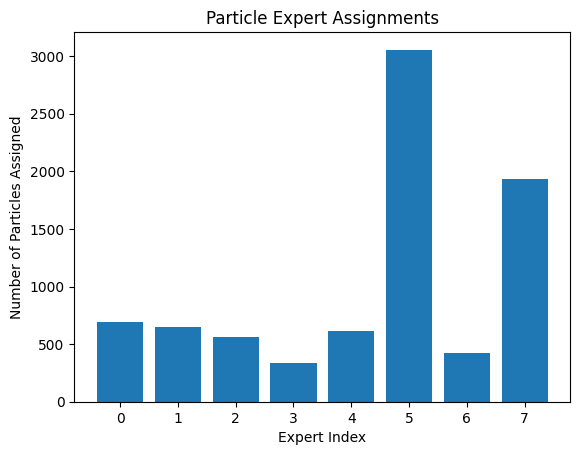

In [ ]:
import matplotlib.pyplot as plt

particle_assignments = np.array(router_hook.expert_assignments)
particle_assignments_hist = np.sum(particle_assignments, axis=0)
np.save('/moe-interpretability-pv/particle_expert_assignments_label1.npy', particle_assignments)
plt.bar(np.arange(router_hook.model.moe_num_experts), particle_assignments_hist)
plt.xlabel('Expert Index')
plt.ylabel('Number of Particles Assigned')
plt.title('Particle Expert Assignments')
plt.show()

In [129]:
print(router_hook.cls_expert_weights[:20])
print(router_hook.cls_expert_assignments.shape)

tensor([[0.0000, 0.0000, 0.0000, 0.5502, 0.0000, 0.0000, 0.0000, 0.4498],
        [0.5054, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4946],
        [0.0000, 0.0000, 0.5057, 0.0000, 0.0000, 0.4943, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5475, 0.4525, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4186, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5814],
        [0.0000, 0.0000, 0.0000, 0.4812, 0.0000, 0.0000, 0.0000, 0.5188],
        [0.0000, 0.0000, 0.5401, 0.4599, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4584, 0.0000, 0.0000, 0.0000, 0.5416],
        [0.0000, 0.0000, 0.4523, 0.0000, 0.0000, 0.0000, 0.0000, 0.5477],
        [0.4873, 0.0000, 0.0000, 0.0000, 0.0000, 0.5127, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4858, 0.5142, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4809, 0.5191, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5261, 0.0000, 0.4739, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.465

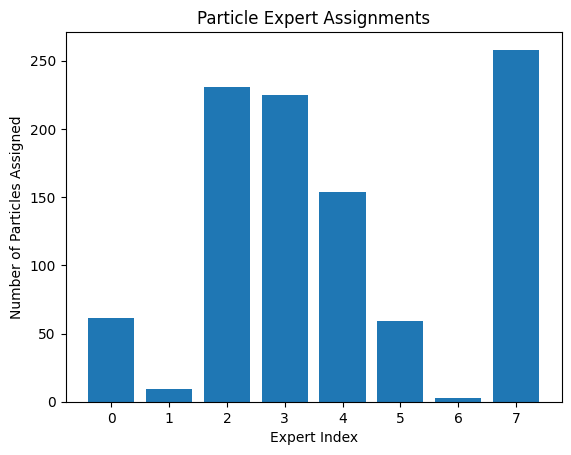

In [ ]:
class_assignments = np.array(router_hook.cls_expert_assignments)
class_assignments_hist = np.sum(class_assignments, axis=0)
np.save('/moe-interpretability-pv/particle_class_assignments_label1.npy', particle_assignments)
plt.bar(np.arange(router_hook.model.moe_num_experts), class_assignments_hist)
plt.xlabel('Expert Index')
plt.ylabel('Number of Particles Assigned')
plt.title('Particle Expert Assignments')
plt.show()

In [ ]:
# PLAN: Sort by assigned expert
# Define feature subspaces to search for correlations e.g. angular space, momentum, charge, particle type
# Compute average norm between all particles of given expert in these subspaces
# In the average, weight by the expert's weighting
# Could do scatterplots to demonstrate

In [ ]:
# Angular subspace: (eta, phi) at indices 

In [141]:
# Charge, particle types at indices 5 and 6-10 (ChargedHadron, NeutralHadron, Photon, Electron, Muon)

flat_features = features.transpose(0,2,1) # (N, C, P) -> (N, P, C)

# features: (N, P, C) -> (N*P, C)
flat_features = flat_features.reshape(-1, features.shape[1])

print(flat_features.shape)
print(features[0,:,1])
print(flat_features[1,:])
flat_features = flat_features[router_hook.valid_indices,:]
print(f'{not ~flat_features[:,0].any()} should be true if no padded particles')
print(flat_features[-100:,0].any())
print(flat_features.shape)

assignments = {i: [] for i in range(router_hook.model.moe_num_experts)}
weights = {i: [] for i in range(router_hook.model.moe_num_experts)}

(12800, 17)
[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]
[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]
True should be true if no padded particles
True
(4130, 17)


In [31]:
for part in range(len(flat_features)):
    for expert in range(router_hook.model.moe_num_experts):
        if router_hook.expert_assignments[part, expert] == 1:
            assignments[expert].append(flat_features[part,:])
            weights[expert].append(router_hook.expert_weights[part, expert])

In [32]:
print(assignments[3][0])

[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]


In [42]:
# Then look at assignments, which combinations are the most common?
# Probably create 2D grid to demonstrate

expert_pairs = np.zeros((router_hook.model.moe_num_experts, router_hook.model.moe_num_experts))

for part in router_hook.expert_assignments:
    assigned_experts = np.where(part==1)[0]
    expert_pairs[assigned_experts[0], assigned_experts[1]] += 1
    expert_pairs[assigned_experts[1], assigned_experts[0]] += 1
    # normalize to fractions of total particles
    

In [46]:
print(expert_pairs)

[[0.000e+00 9.200e+01 1.900e+01 5.400e+01 3.870e+02 2.667e+03 0.000e+00
  1.180e+02]
 [9.200e+01 0.000e+00 9.600e+01 1.400e+01 3.200e+01 2.552e+03 0.000e+00
  2.430e+02]
 [1.900e+01 9.600e+01 0.000e+00 6.500e+01 1.860e+02 2.569e+03 3.000e+00
  2.050e+02]
 [5.400e+01 1.400e+01 6.500e+01 0.000e+00 4.110e+02 7.400e+02 0.000e+00
  4.840e+02]
 [3.870e+02 3.200e+01 1.860e+02 4.110e+02 0.000e+00 1.250e+03 6.000e+00
  9.900e+02]
 [2.667e+03 2.552e+03 2.569e+03 7.400e+02 1.250e+03 0.000e+00 6.100e+01
  5.339e+03]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 6.000e+00 6.100e+01 0.000e+00
  1.992e+03]
 [1.180e+02 2.430e+02 2.050e+02 4.840e+02 9.900e+02 5.339e+03 1.992e+03
  0.000e+00]]


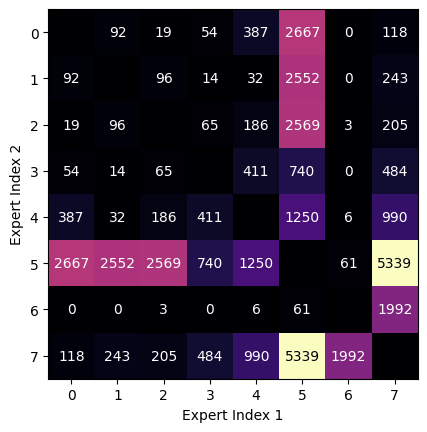

In [48]:
fig, ax = plt.subplots()
im = ax.imshow(expert_pairs, cmap='magma')

rows, cols = expert_pairs.shape
for i in range(rows):
    for j in range(cols):
        if j != i:
            text = ax.text(j, i, int(expert_pairs[i, j]),
                       ha="center", va="center", color="w") # Customize text color if needed
        if [i,j] == [5,7] or [i,j] == [7,5]:
            text = ax.text(j, i, int(expert_pairs[i, j]),
                       ha="center", va="center", color="black") # Customize text color if needed

plt.xlabel('Expert Index 1')
plt.ylabel('Expert Index 2')
plt.show()

In [ ]:
# consider high-level overviews: for each decay, plot expert distributions
# consider for particle types, what experts like them
# consider ranges of pT
# consider angle off the jet-axis to indicate particular decay, also (px, py, pz) if we can get some good scaling
# we'd like the model to recognize cross-section etc.
# probably some automation to generate plots more efficiently

In [ ]:
# consider looking at 'distinguisher' particles - e.g. large d(deltaR), high pt_rel, high e_rel

In [85]:
parts_by_expert = {i: [] for i in range(router_hook.model.moe_num_experts)}

for expert in range(router_hook.model.moe_num_experts):
    for part_idx, part_assignment in enumerate(router_hook.expert_assignments):
        if router_hook.expert_assignments[part_idx, expert] == 1:
            parts_by_expert[expert].append(flat_features[part_idx,:])

In [86]:
print(parts_by_expert[1][0])

[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]


In [87]:
print(parts_by_expert[5][1])

[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]


In [88]:
feature_ids = {
    0: 'part_pt_log',
    1: 'part_e_log',
    2: 'part_logptrel',
    3: 'part_logerel',
    4: 'part_deltaR',
    5: 'part_charge',
    6: 'part_isChargedHadron',
    7: 'part_isNeutralHadron',
    8: 'part_isPhoton',
    9: 'part_isElectron',
    10: 'part_isMuon',
    11: 'part_d0',
    12: 'part_d0err',
    13: 'part_dz',
    14: 'part_dzerr',
    15: 'part_deta',
    16: 'part_dphi'
}

In [96]:
# Track incidence of particle types, feature ids 6-10

for expert in parts_by_expert.keys():
    part_types = {feature_ids[i]: 0 for i in range(6,11)}
    for part in parts_by_expert[expert]:
        for feature_id in range(6,11):
            part_types[feature_ids[feature_id]] += part[feature_id]
    for key in part_types.keys():
        part_types[key] = part_types[key] / len(parts_by_expert[expert])
    print(f'Expert {expert} particle types: {part_types}')

Expert 0 particle types: {'part_isChargedHadron': 0.4538904899135447, 'part_isNeutralHadron': 0.0792507204610951, 'part_isPhoton': 0.4409221902017291, 'part_isElectron': 0.01729106628242075, 'part_isMuon': 0.008645533141210375}
Expert 1 particle types: {'part_isChargedHadron': 0.43859649122807015, 'part_isNeutralHadron': 0.11802232854864433, 'part_isPhoton': 0.405103668261563, 'part_isElectron': 0.02073365231259968, 'part_isMuon': 0.017543859649122806}
Expert 2 particle types: {'part_isChargedHadron': 0.4858156028368794, 'part_isNeutralHadron': 0.08687943262411348, 'part_isPhoton': 0.39361702127659576, 'part_isElectron': 0.02127659574468085, 'part_isMuon': 0.012411347517730497}
Expert 3 particle types: {'part_isChargedHadron': 0.45791245791245794, 'part_isNeutralHadron': 0.11447811447811448, 'part_isPhoton': 0.4175084175084175, 'part_isElectron': 0.003367003367003367, 'part_isMuon': 0.006734006734006734}
Expert 4 particle types: {'part_isChargedHadron': 0.4937888198757764, 'part_isNeut

In [ ]:
# Track average pt_rel, e_rel, and std. devs

for expert in parts_by_expert.keys():
    pt_rels = []
    e_rels = []
    for part in parts_by_expert[expert]:
        pt_rels.append(part[2])
        e_rels.append(part[3])
    pt_rels = np.array(pt_rels)
    e_rels = np.array(e_rels)
    print(f'Expert {expert} pt_rel: mean {np.mean(pt_rels)}, std. dev. {np.std(pt_rels)}')
    print(f'Expert {expert} e_rel: mean {np.mean(e_rels)}, std. dev. {np.std(e_rels)}')

In [ ]:
# from presoftmax attentions, search for induction heads
# i.e. heads that reproduce previously processed particles

In [ ]:
# Notes 10/16



In [ ]:
# plot distribution of pt_rel for all experts
plt.figure(figsize=(10,6))
for expert in parts_by_expert.keys():
    pt_rels = []
    for part in parts_by_expert[expert]:
        pt_rels.append(part[2])
    plt.hist(pt_rels, bins=50, alpha=0.5, histtype='step', label=f'Expert {expert}', density=True)
plt.xlabel('pt_rel')
plt.ylabel('Density')
plt.title(f'Distribution of pt_rel by Expert - Jet Type {jet_type}')
plt.legend()
#plt.savefig(f'/moe-interpretability-pv/plots/pt_rel_distribution_{jet_type.replace(" ","_")}_{jet_type}.png')
plt.show()